In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [20]:
# Load preprocessed data
x_input = np.load('prepared_data/x_input_combined.npy')
y_output = np.load('prepared_data/y_output_combined.npy')

y_output = to_categorical(y_output, num_classes=4)

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_input, y_output, test_size=0.2, random_state=42)

In [21]:
# Initialize DenseNet121 base
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom top layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation='softmax')(x)


In [22]:
# Optionally freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint_DenseNet = ModelCheckpoint('model_checkpoints/DenseNet_brain_tumor.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping_DenseNet = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint_DenseNet, early_stopping_DenseNet]
)


Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.4846 - loss: 1.4951
Epoch 1: val_loss improved from inf to 0.52393, saving model to model_checkpoints/DenseNet_brain_tumor.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.4871 - loss: 1.4855 - val_accuracy: 0.8255 - val_loss: 0.5239
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.7864 - loss: 0.5362
Epoch 2: val_loss improved from 0.52393 to 0.41136, saving model to model_checkpoints/DenseNet_brain_tumor.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7865 - loss: 0.5360 - val_accuracy: 0.8333 - val_loss: 0.4114
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.8516 - loss: 0.4057
Epoch 3: val_loss improved from 0.41136 to 0.37033, saving model to model_checkpoints/DenseNet_brain_tumor.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8518 - loss: 0.4051 - val_accuracy: 0.8620 - val_loss: 0.3703
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy

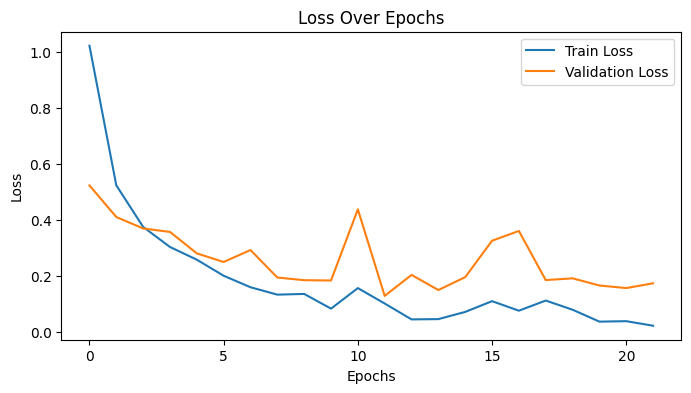

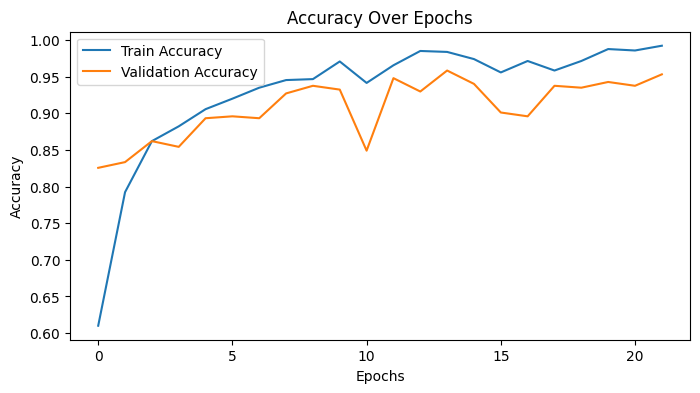

In [23]:
def plot_metrics(history):
    # Plot Loss
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history)

12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 762ms/step


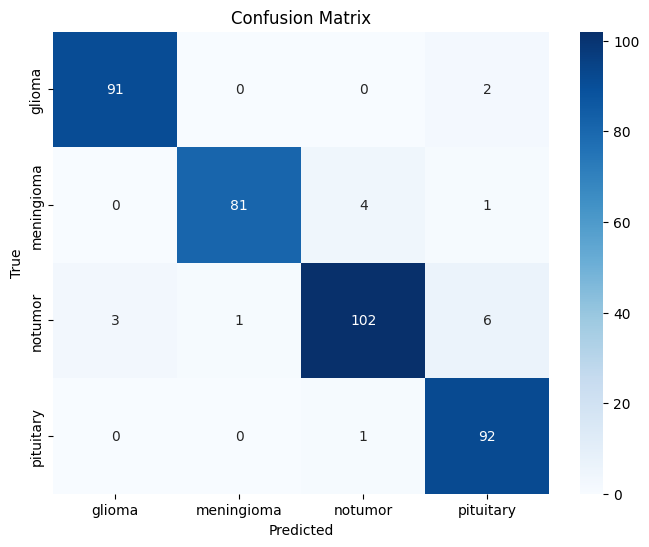

Accuracy: 0.953125
Precision: 0.9550130253945133
Recall: 0.9550791715786089
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97        93
           1       0.99      0.94      0.96        86
           2       0.95      0.91      0.93       112
           3       0.91      0.99      0.95        93

    accuracy                           0.95       384
   macro avg       0.96      0.96      0.95       384
weighted avg       0.95      0.95      0.95       384



In [24]:
# Make predictions
predictions = model.predict(x_val)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_val, axis=1)
conf_matrix = confusion_matrix(true_classes, predicted_classes)

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Confusion Matrix and Classification Report

class_report = classification_report(true_classes, predicted_classes)
print("Classification Report:\n", class_report)